In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_23606/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [2]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

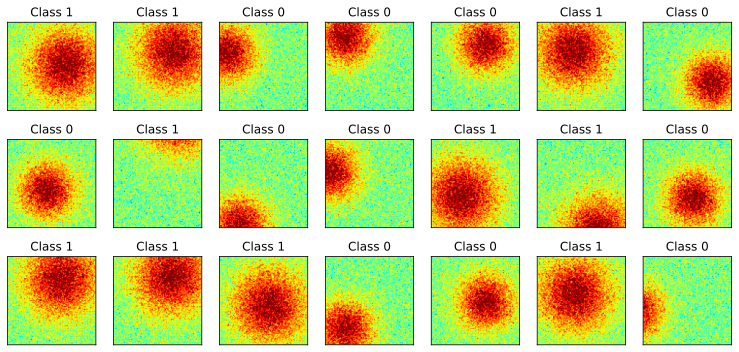

In [3]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [4]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [5]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      

      # soft-coded variables
      k = (3,2)
      s = (2,3)

      ### conv1
      self.conv1 = nn.Conv2d(1,3,k,s)
      
      # output of convolution layer (second line is for pooling layer)
      imsizeW = np.floor( (91+2*self.conv1.padding[1]-k[1])/s[1] ) + 1
      imsizeW = np.floor( imsizeW/2 )
      imsizeH = np.floor( (91+2*self.conv1.padding[0]-k[0])/s[0] ) + 1
      imsizeH = np.floor( imsizeH/2 )


      ### conv2
      self.conv2 = nn.Conv2d(3,6,k,s)
      
      # output of convolution layer (second line is for pooling layer)
      # notice that it requires the image size from the previous conv-pool layer
      imsizeW = np.floor( (imsizeW+2*self.conv1.padding[1]-k[1])/s[1] ) + 1
      imsizeW = int( imsizeW/2 ) # input to nn.Linear must be ints, and int() rounds down
      imsizeH = np.floor( (imsizeH+2*self.conv1.padding[0]-k[0])/s[0] ) + 1
      imsizeH = int( imsizeH/2 ) # input to nn.Linear must be ints, and int() rounds down

      
      # fc1 (soft-coded number of input units!)
      self.fc1 = nn.Linear(imsizeW*imsizeH*self.conv2.out_channels,50)

      # fc2 (output)
      self.fc2 = nn.Linear(50,1)
      
    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1act,(2,2))
      
      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2act,(2,2))

      # ANN part
      x = x.reshape(x.shape[0],-1)
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)
      
      return x,conv1act,conv2act
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [6]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

# test that the model runs and can compute a loss
X,y = next(iter(train_loader))
yHat,featmap1,featmap2 = net(X)
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 3, 45, 30])

Feature map after conv2
torch.Size([32, 6, 10, 5])


# Create a function that trains the model

In [7]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model and show the results!

In [8]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

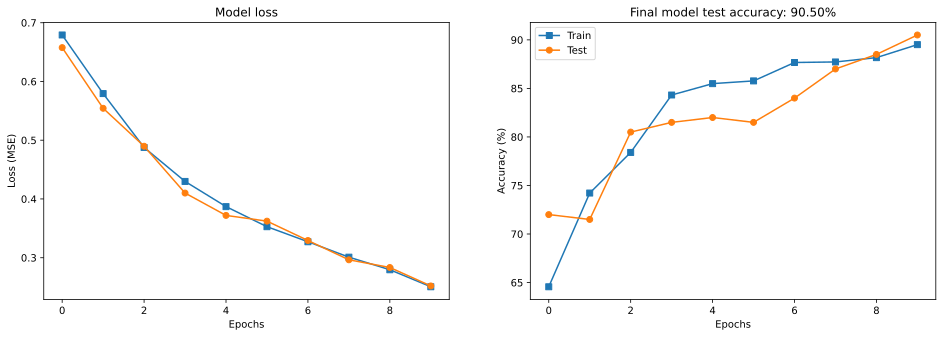

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

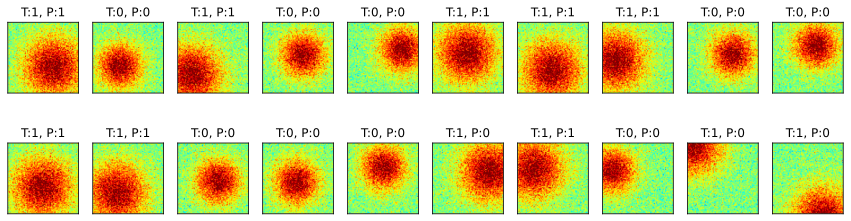

In [10]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>.5) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Draw the feature maps

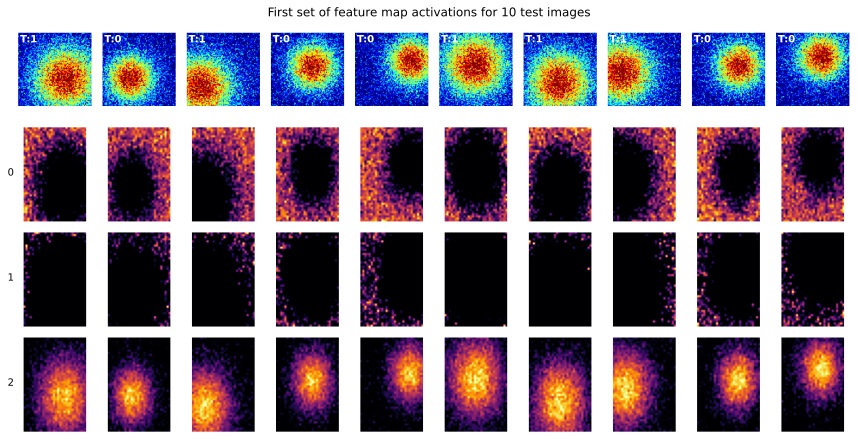

In [11]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(featmap1.shape[1]+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(featmap1.shape[1]):
      # extract the feature map from this image
      img = featmap1[pici,feati,:,:].detach()
      axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
      axs[feati+1,pici].axis('off')
      axs[feati+1,pici].text(-5,featmap1.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

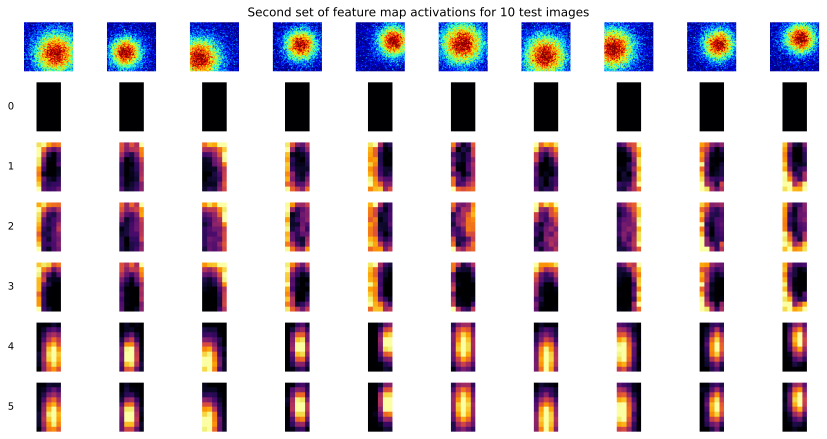

In [12]:
# Repeat for feature2 maps

fig,axs = plt.subplots(featmap2.shape[1]+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(featmap2.shape[1]):
      # extract the feature map from this image
      img = featmap2[pici,feati,:,:].detach()
      axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
      axs[feati+1,pici].axis('off')
      axs[feati+1,pici].text(-5,featmap2.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

# Spatial correlations across the feature maps

/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


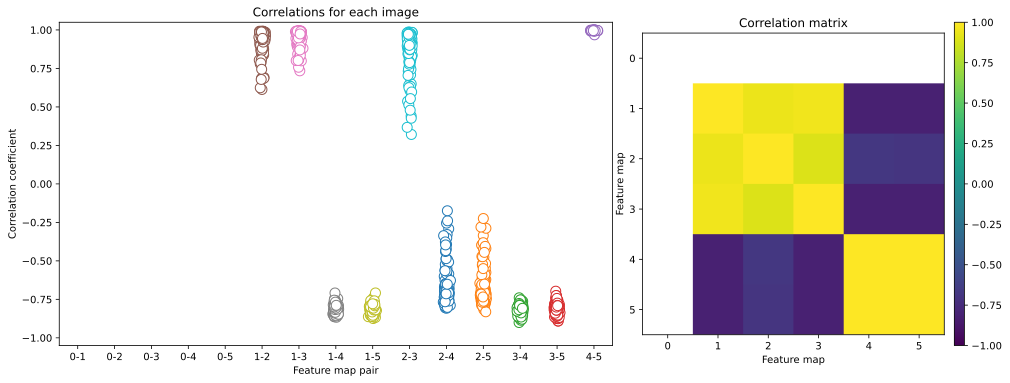

In [13]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(14,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.99,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

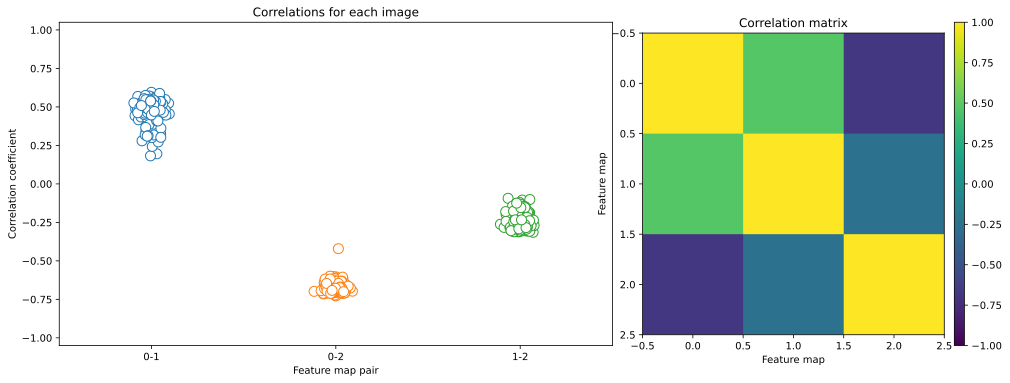

In [14]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(14,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.99,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()